Завдання -  Аналіз датасету:
1. Проаналізуй основні поведінкові патерни, тренди в датасеті.
2. Побудуй просту модель або логіку, яка видає рекомендацію: які саммарі показувати користувачу далі, базуючись на тому, що він уже читав.

## Перейдемо до завдання про аналіз основних поведінкових патернів, трендів в датасеті.

In [1]:
import pandas as pd

reading_df = pd.read_csv('/content/drive/MyDrive/ТЗ /Product Analyst, Headway/data_reading.csv', parse_dates=['event_time'])
summary_df = pd.read_csv('/content/drive/MyDrive/ТЗ /Product Analyst, Headway/summary_info.csv')

In [2]:
reading_df.head(5)

,Unnamed: 0,user_id,event_time,country,event_type,event_properties_book_id,event_properties_format
0,0,LM49ELXC,2024-06-02 04:25:35,United States,summary_last_page,0dbe62f1ca984daf881a,text
1,1,7XTQHMH8,2024-06-03 21:46:51,Spain,summary_start,WUOlTHMd11KUsvKSMhPx,audio
2,2,2IB2IK8U,2024-05-17 18:47:01,United States,summary_start,AJfjqmnZfcGYTpDtYhzz,audio
3,3,O9C6WXJE,2024-06-07 01:18:14,United States,summary_start,1384d32a0cc5415ba60b,audio
4,4,4GRWXHNP,2024-05-03 13:16:34,Hong Kong,summary_last_page,1Z9KhNI1CyXJMDXEDdgN,audio


In [3]:
summary_df.head(5)

,topic,book_id
0,Health,012399fc36f74c489e4e
1,Health,01b85da7d21c478ab4b1
2,Health,0eef51fd8ce54d51bff6
3,Health,0efd511e57ea414ab5ab
4,Health,1251469de9ce40deace4


In [4]:
#обʼєдную таблиці для аналізу
finale_df = reading_df.merge(
    summary_df,
    how='left',
    left_on='event_properties_book_id',
    right_on='book_id'
)

In [5]:
finale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308940 entries, 0 to 1308939
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   Unnamed: 0                1308940 non-null  int64         
 1   user_id                   1308940 non-null  object        
 2   event_time                1308940 non-null  datetime64[ns]
 3   country                   1308940 non-null  object        
 4   event_type                1308940 non-null  object        
 5   event_properties_book_id  1308940 non-null  object        
 6   event_properties_format   1308940 non-null  object        
 7   topic                     1236232 non-null  object        
 8   book_id                   1236232 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 89.9+ MB


Бачу, що кількість рядків в topic  менша, ніж event_properties_book_id. Для точної аналітики потрібно очистити тоді дані.

In [6]:
finale_df_clean = finale_df.dropna(subset=['topic'])

In [7]:
#важливо побачити категорії топіків які читають - виведу ТОП 10 + унікальні користувачі
starts = finale_df_clean[finale_df_clean['event_type'] == 'summary_start']
starts_by_topic = starts.groupby('topic')['user_id'].nunique().sort_values(ascending=False).head(10)

#тепер хочу переглянути найдочитуваніші категорії - ТОП 10 + унікальні користувачі
finishes = finale_df_clean[finale_df_clean['event_type'] == 'summary_last_page']
finishes_by_topic = finishes.groupby('topic')['user_id'].nunique().sort_values(ascending=False).head(10)

display(starts_by_topic, finishes_by_topic)

,user_id
topic,
Daily Optimization,36523
Financial Management,19232
Communication Skills,18748
Persuasion Techniques,18464
Mindfulness,17759
Time Management,16884
Negotiation Skills,16236
Entrepreneurship,14798
Mind Enhancement,13630


,user_id
topic,
Daily Optimization,30962
Financial Management,16145
Communication Skills,15193
Persuasion Techniques,15123
Mindfulness,14979
Time Management,14102
Negotiation Skills,13158
Entrepreneurship,12104
Intention Setting,11870


In [8]:
#обʼєднаю в одну таблицію та порахую completion rate
completion_df = pd.DataFrame({
    'starts': starts_by_topic,
    'finishes': finishes_by_topic
}).fillna(0)

completion_df['completion_rate'] = (completion_df['finishes'] / completion_df['starts']).round(3)

completion_df.sort_values(by='completion_rate', ascending=False).head(10)

,starts,finishes,completion_rate
topic,,,
Intention Setting,13528,11870,0.877
Daily Optimization,36523,30962,0.848
Mind Enhancement,13630,11555,0.848
Mindfulness,17759,14979,0.843
Financial Management,19232,16145,0.839
Time Management,16884,14102,0.835
Persuasion Techniques,18464,15123,0.819
Entrepreneurship,14798,12104,0.818
Communication Skills,18748,15193,0.810


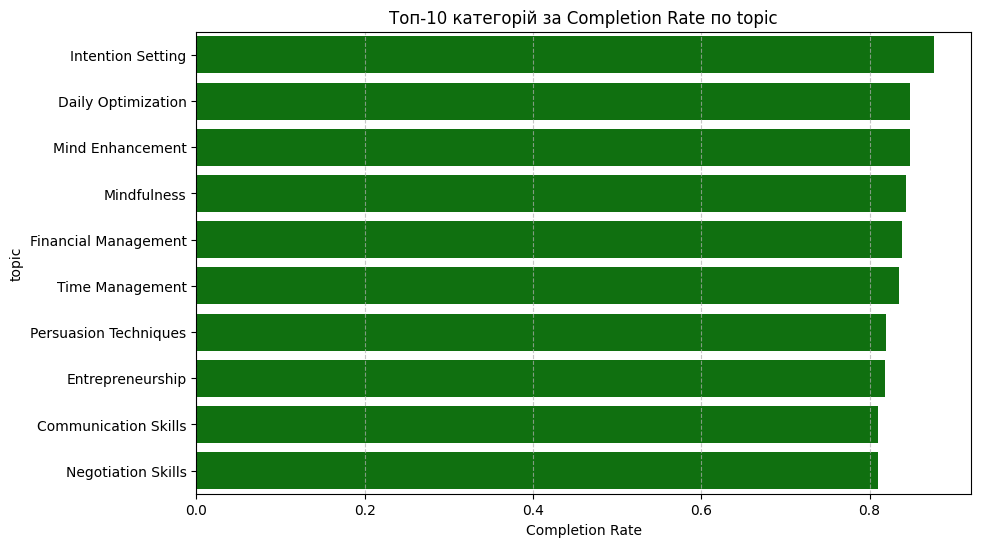

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

top_completion = completion_df.sort_values(by='completion_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_completion, y=top_completion.index, x='completion_rate', color= 'green')

plt.title('Топ-10 категорій за Completion Rate по topic')
plt.xlabel('Completion Rate')
plt.ylabel('topic')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show();

**Що бачимо:**

* Найкраще дочитують теми, повʼязані з особистим фокусом та самопокращенням: `Intention Setting` має найвищий completion rate — 87.7%

* Далі `Daily Optimization`, `Mind Enhancement`, `Mindfulness` - всі понад 84%

* Теми повʼязані з навичками показують нижче залучення - 81%


In [10]:
#тепер подивлюсь більше читають чи слухають
starts = finale_df_clean[finale_df_clean['event_type'] == 'summary_start']
starts_by_format = starts.groupby('event_properties_format')['user_id'].nunique()

finishes = finale_df_clean[finale_df_clean['event_type'] == 'summary_last_page']
finishes_by_format = finishes.groupby('event_properties_format')['user_id'].nunique()

display(starts_by_format, finishes_by_format)

,user_id
event_properties_format,
audio,117708
text,39528


,user_id
event_properties_format,
audio,95266
text,27787


In [11]:
#обʼєднаю в одну таблицію та порахую completion rate
format_stats = pd.DataFrame({
    'starts': starts_by_format,
    'finishes': finishes_by_format
}).fillna(0)

format_stats['completion_rate'] = (format_stats['finishes'] / format_stats['starts']).round(3)
format_stats

,starts,finishes,completion_rate
event_properties_format,,,
audio,117708,95266,0.809
text,39528,27787,0.703


**Що бачимо:**

* Формат audio — основний. Його обрали майже в 3 рази частіше, ніж текст.

* Аудіо також має кращу конверсію в дочитування - різниця майже в 10%.


In [12]:
#цікаво переглянути також країни та знайти ТОП 10
starts_by_country = starts.groupby('country')['user_id'].nunique()
finishes_by_country = finishes.groupby('country')['user_id'].nunique()

country_stats = pd.DataFrame({
    'starts': starts_by_country,
    'finishes': finishes_by_country
}).fillna(0)

country_stats['completion_rate'] = (country_stats['finishes'] / country_stats['starts']).round(3)

country_stats.sort_values(by='starts', ascending=False).head(10)


,starts,finishes,completion_rate
country,,,
United States,65152.0,51001.0,0.783
United Kingdom,11283.0,8710.0,0.772
Mexico,7884.0,6513.0,0.826
Australia,7065.0,5415.0,0.766
Canada,6519.0,4910.0,0.753
Colombia,4500.0,3656.0,0.812
Spain,4161.0,3176.0,0.763
Chile,3246.0,2602.0,0.802
Germany,2366.0,1935.0,0.818


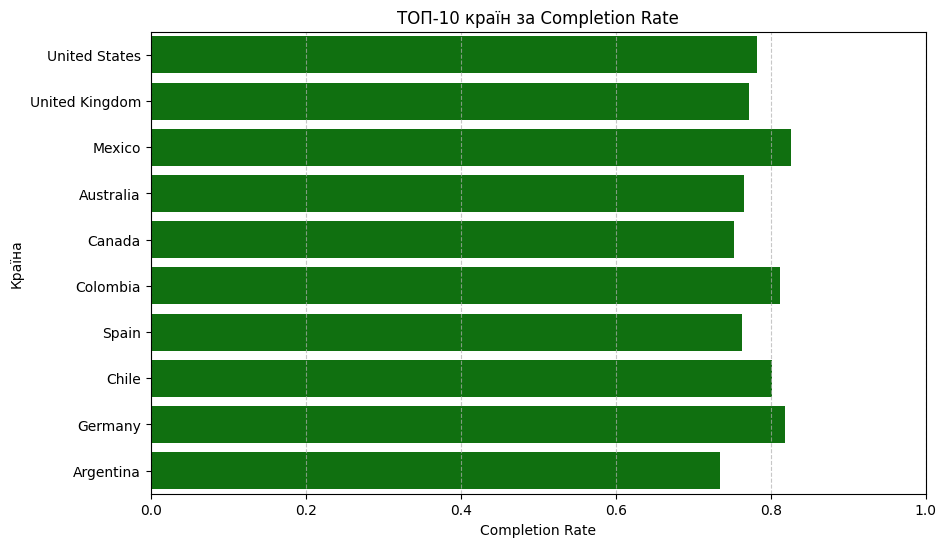

In [13]:
top_countries = country_stats.sort_values(by='starts', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='completion_rate', y=top_countries.index, color= 'green')

plt.title('ТОП-10 країн за Completion Rate')
plt.xlabel('Completion Rate')
plt.ylabel('Країна')
plt.xlim(0, 1)  # бо рейт не може бути >1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show();

**Що бачимо:**

* Є три лідери по дочитуванню - `Mexico` - 82.6%, `Germany` — 81.8%, `Colombia` — 81.2%

* Найнижча дочитуваність — у `Argentina` - 73.5%

In [17]:
#по годині дочитування цікаво також порівняти
finale_df_clean.loc[:, 'hour'] = finale_df_clean['event_time'].dt.hour

starts_by_hour = finale_df_clean[finale_df_clean['event_type'] == 'summary_start'].groupby('hour')['user_id'].nunique()
finishes_by_hour = finale_df_clean[finale_df_clean['event_type'] == 'summary_last_page'].groupby('hour')['user_id'].nunique()

hour_stats = pd.DataFrame({
    'starts': starts_by_hour,
    'finishes': finishes_by_hour
}).fillna(0)

hour_stats['completion_rate'] = (hour_stats['finishes'] / hour_stats['starts']).round(3)
hour_stats.sort_values(by='completion_rate', ascending=False).head(10)

,starts,finishes,completion_rate
hour,,,
7,6103,5321,0.872
16,10101,8773,0.869
15,11055,9588,0.867
14,12252,10604,0.865
13,13070,11302,0.865
6,7109,6093,0.857
17,9363,7968,0.851
5,7692,6525,0.848
22,8901,7506,0.843


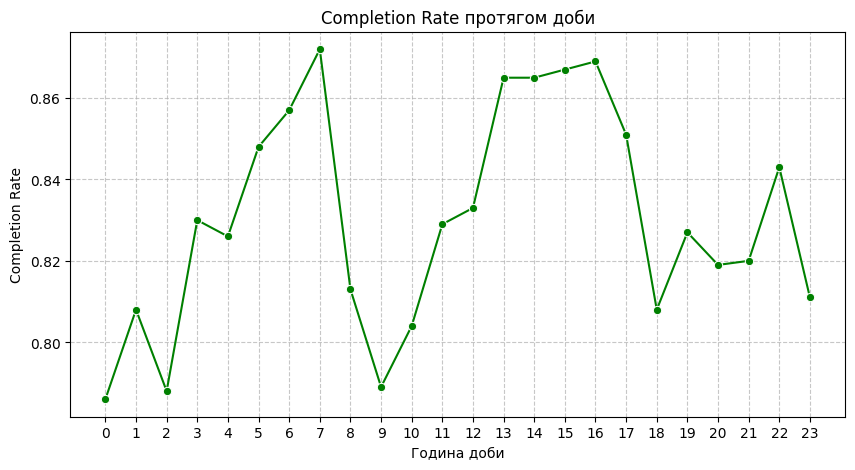

In [18]:
hour_stats_sorted = hour_stats.sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hour_stats_sorted, x=hour_stats_sorted.index, y='completion_rate', marker='o', color='green')

plt.title('Completion Rate протягом доби')
plt.xlabel('Година доби')
plt.ylabel('Completion Rate')
plt.xticks(range(0, 24))
plt.grid(linestyle='--', alpha=0.7)
plt.show();

**Що бачимо:**

* Найвища дочитуваність — зранку, о `7 годині ранку` - 87.2%.
6 ранку та 5 ранку - також мають гарні показники дочитуваності.

* Час обідньої перерви - `13- 16 година ` також мають гарні показники - 86%.

* Вечірній час - `22 година ` - мають меншу залученість трішки.

**Важливий момент:**

Цей аналіз проведено загалом по всій аудиторії, без поділу на часові зони.
Оскільки найбільша частка юзерів — із США, час читання значною мірою відображає їхню активність.
Для глибшого розуміння патернів у різних регіонах — варто провести окремий аналіз по країнах і локальному часу.

## Перейдемо до завдання побудови простої моделі або логіки, яка видає рекомендацію: які саммарі показувати користувачу далі, базуючись на тому, що він уже читав.

Найпростішим, мені здається, буде запропонувати користувачу інші саммері, які він ще не читав в тому топіку, який для нього є найдочитуванішим.

In [19]:
#визначу саммері, які дочитав юзер, а потім виокремлю теми
finishes = finale_df_clean[finale_df_clean['event_type'] == 'summary_last_page']

user_reads = finishes.groupby('user_id')['event_properties_book_id'].unique().reset_index()
user_reads.columns = ['user_id', 'read_books']

top_topics = finishes.groupby(['user_id', 'topic']).size().reset_index(name='count')

top_topic_by_user = top_topics.sort_values('count', ascending=False).drop_duplicates('user_id')

In [20]:
#тепер треба зрозуміти, а які книги юзер ще НЕ читав з цієї теми
user_recs = top_topic_by_user.merge(summary_df, on='topic', how='left')
user_recs = user_recs.merge(user_reads, on='user_id', how='left')

def not_read(row):
    return row['book_id'] not in row['read_books']

user_recs['is_new'] = user_recs.apply(not_read, axis=1)
final_recs = user_recs[user_recs['is_new']]

In [21]:
#виводжу фінальний список рекомендацій
final_recs = user_recs[user_recs['is_new']]
recommendations = final_recs.groupby('user_id').head(3)

recommendations[['user_id', 'book_id', 'topic']].head(20)
#у нас дійсно є user_id	в данних,  які мають такі назви, тому вивела трішки більше рядків, щоб переглянути і "стандартний" user_id

,user_id,book_id,topic
0,INVALID,012399fc36f74c489e4e,Daily Optimization
6,INVALID,16ofYUtbtZY4VSGTeVCz,Daily Optimization
7,INVALID,1B1eRmHJIT1vNGSWws4g,Daily Optimization
96,###,012399fc36f74c489e4e,Daily Optimization
99,###,0f3453e981a146b5b52c,Daily Optimization
101,###,1309bd3d29f842c1beb6,Daily Optimization
195,broken_id,0f3453e981a146b5b52c,Daily Optimization
196,broken_id,1251469de9ce40deace4,Daily Optimization
198,broken_id,16ofYUtbtZY4VSGTeVCz,Daily Optimization
288,???,012399fc36f74c489e4e,Daily Optimization


In [22]:
#збережу файл у CSV
recommendations[['user_id', 'book_id', 'topic']].to_csv('final_recommendations.csv', index=False)

**Що зробили:**

Побудували базову логіку рекомендацій, яка підказує користувачу, що прочитати далі на основі його інтересів.

Рекомендація базується на:

* Аналізі прочитаних саммері (тільки тих, які вже були дочитані користувачем).

* Визначенні найулюбленішої теми користувача.

* Пошуку нових саммері з цієї ж теми, які користувач ще не читав.

Це проста, але вже персоналізована логіка рекомендацій. Її звичайно можна удосконалювати.